In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preparation**

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'NIND' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
    get_ipython().system_raw('7z x NIND.zip -o/content/ && rm NIND.zip')

Downloading...
From: https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
To: /content/NIND.zip
3.22GB [00:45, 70.0MB/s]


In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'Mi3_Aligned' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
    get_ipython().system_raw('7z x Mi3_Aligned.zip -o/content/ && rm Mi3_Aligned.zip')

Downloading...
From: https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
To: /content/Mi3_Aligned.zip
2.71GB [01:06, 41.0MB/s]


In [ ]:
# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [02:40, 41.3MB/s]


In [5]:
def get_images_paths( root_dir_mi):
    # Getting SSID dataset images
    # root = pathlib.Path(root_dir_ssid)
    # img_paths = list(root.rglob("*.PNG*"))
    # img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    # for p in img_paths_lst:
    #     img_type = p.split("/")[-1].split('_')[-3]
    #     if img_type=="NOISY":
    #         noisy_lst.append(p)
    #     elif img_type=="GT":
    #         gt_lst.append(p)

    # Getting mi dataset images
    root = pathlib.Path(root_dir_mi)
    img_paths = list(root.rglob("*.bmp*"))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-1]
        if "Noisy" in img_type:
            noisy_lst.append(p)
        elif "Reference" in img_type:
            gt_lst.append(p)
            gt_lst.append(p)


    # Getting NIND dataset images
    # root = pathlib.Path(root_dir_nind)
    # img_paths = list(root.rglob("*.png*"))
    # img_paths.extend(list(root.rglob("*.jpg*")))
    # img_paths_lst = [str(path) for path in img_paths]

    # for p in img_paths_lst:
    #     img_type = p.split("/")[-1].split("_")[-1]
    #     if "H" in img_type:
    #         noisy_lst.append(p)
    #     else:
    #         gt_lst.append(p)

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [3]:

noisy_lst= []
root=pathlib.Path("/content/drive/MyDrive/mypic")
img_paths = list(root.rglob("*.png*"))
img_paths_lst = [str(path) for path in img_paths]
for p in img_paths_lst:
  noisy_lst.append(p)
my_noisy_paths = np.asarray(noisy_lst)
print(my_noisy_paths.shape)

(4,)


In [9]:
my_noisy_images=get_images_in_mem(my_noisy_paths)
print(my_noisy_images.shape)

  0%|          | 0/4 [00:00<?, ?it/s]

(4, 256, 256, 3)


In [ ]:
# # SANITY CHECK of the NIND image pairs
# for p, q in zip(noisy_lst, gt_lst):
#     n_file_name = p.split("/")[2]
#     n_file_name = n_file_name[n_file_name.find("_"):n_file_name.rfind("_")+1]

#     g_file_name = q.split("/")[2]
#     g_file_name = g_file_name[g_file_name.find("_"):g_file_name.rfind("_")+1]

#     if n_file_name!=g_file_name:
#         print("Something's wrong, I can feel it!",n_file_name,g_file_name)

In [ ]:
# # SANITY check of the mi phone image pairs
# noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned")
# somethings_wrong=False
# mi_counter=0
# for gt_path, noisy_path in zip(gt_array_paths, noisy_array_paths):
#     batch_gt = gt_path.split("/")[1]
#     batch_noisy = noisy_path.split("/")[1]
#     if gt_path.split("/")[0]=="Mi3_Aligned":
#         mi_counter+=1
#         if batch_gt!=batch_noisy:
#             print(gt_path+" -- "+noisy_path)
#             somethings_wrong=True
#             break
# if somethings_wrong:
#     print("Something's wrong, I can feel it!", mi_counter)
# else:
#     print("Nothing to worry!", mi_counter)

In [6]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths( "/content/drive/MyDrive/Mi3_Aligned")

noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)

In [7]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(62,)
(16,)
(62,)
(16,)


In [8]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

(62, 256, 256, 3)
(16, 256, 256, 3)
(62, 256, 256, 3)
(16, 256, 256, 3)


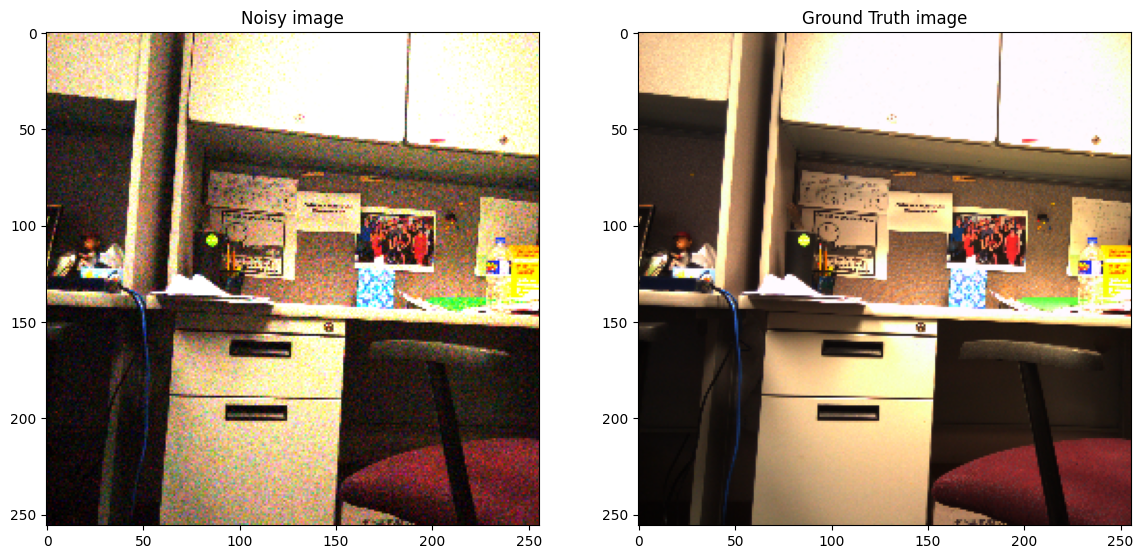

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_train_images[5])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[5])
axarr[1].title.set_text("Ground Truth image")

In [ ]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
# augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [ ]:
image_generator_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None))>

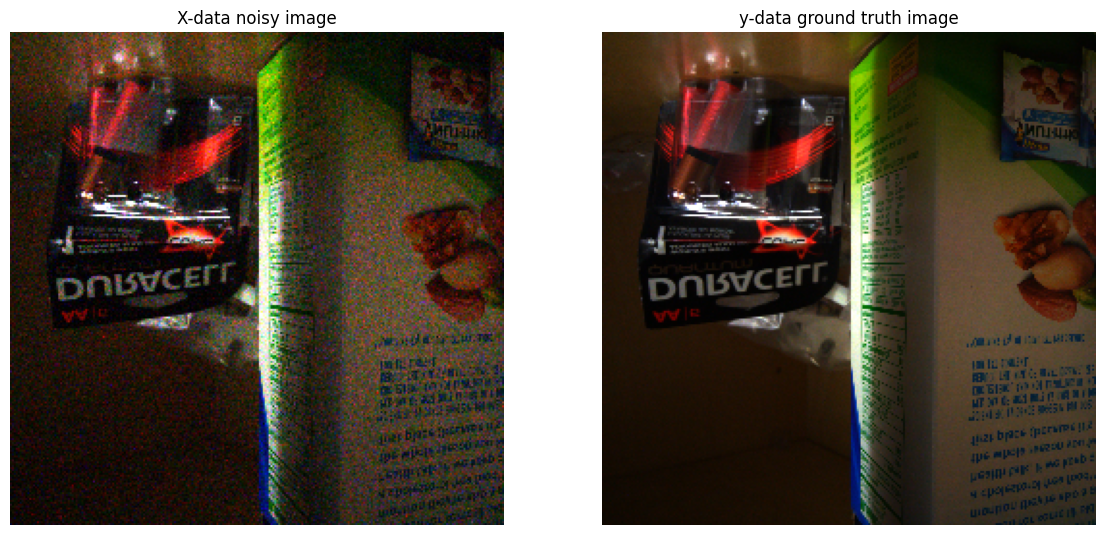

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

# **PRIDNet**
<a href='https://arxiv.org/pdf/1908.00273.pdf'>https://arxiv.org/pdf/1908.00273.pdf</a>


In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

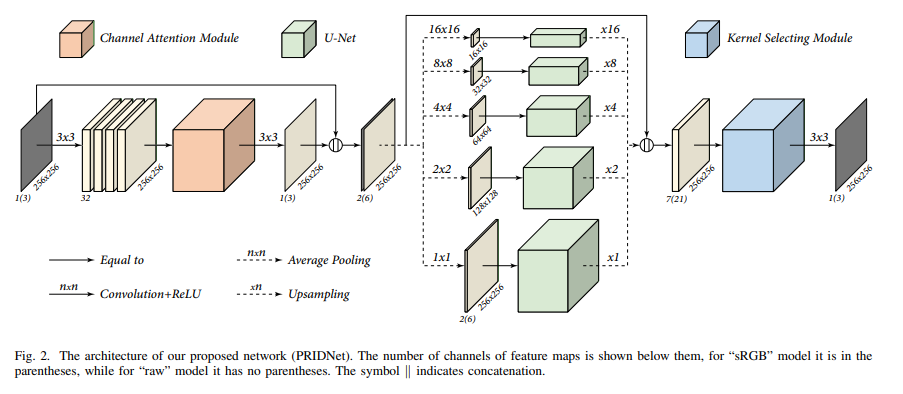

In [24]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

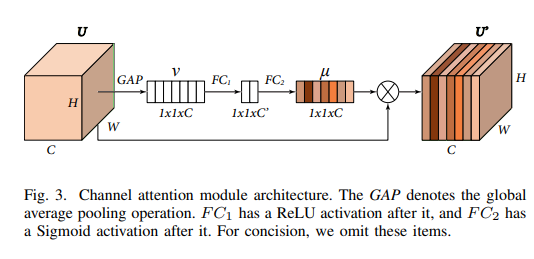

In [25]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

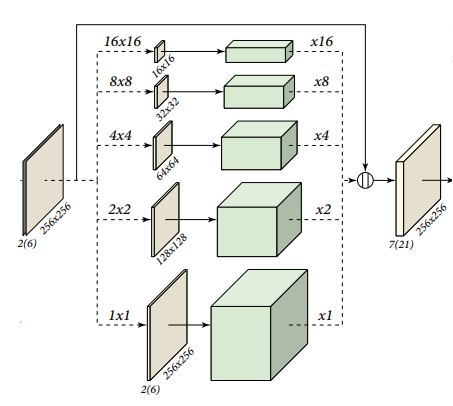

In [26]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [27]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

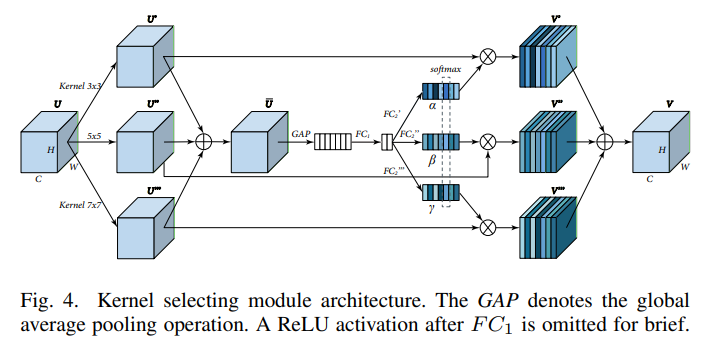

In [28]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [29]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()

Input = (None, 256, 256, 3)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 6)

Multi-scale feature extraction = (None, 256, 256, 21)
Kernel Selection Module = (None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (Convoluti  (None, 256, 256, 64  112576     ['input_layer[0][0]']            
 onal_block)                    )                                                                 
     

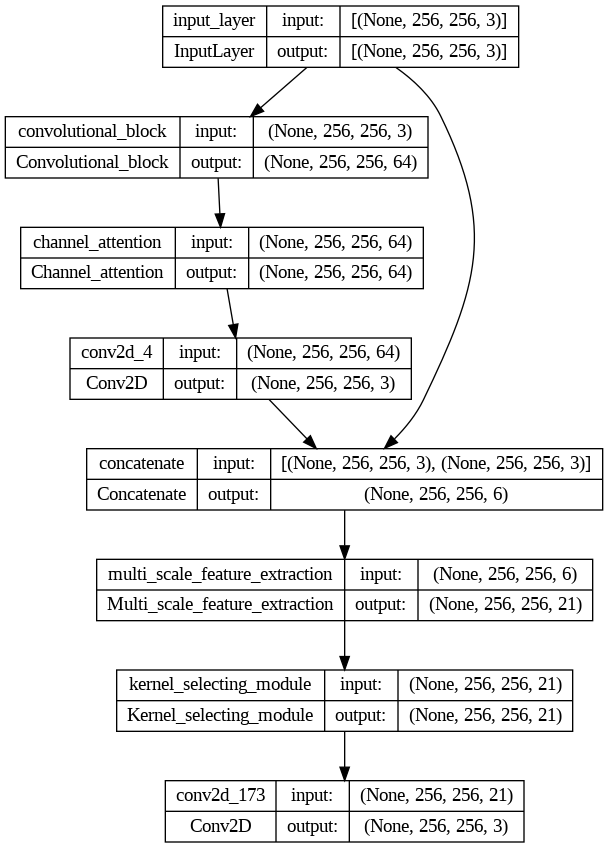

In [30]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

# **Training**

In [ ]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_PRIDNet_blindnoise_256x256.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=150,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/150
62/62 [==============================] - 100s 176ms/step - loss: 60593053696.0000 - val_loss: 3247.4407 - lr: 9.0000e-04
Epoch 2/150
62/62 [==============================] - 8s 131ms/step - loss: 1358.6833 - val_loss: 540.0562 - lr: 9.0000e-04
Epoch 3/150
62/62 [==============================] - 8s 131ms/step - loss: 627.0904 - val_loss: 435.4597 - lr: 9.0000e-04
Epoch 4/150
62/62 [==============================] - 8s 131ms/step - loss: 517.3898 - val_loss: 341.5849 - lr: 9.0000e-04
Epoch 5/150
62/62 [==============================] - 8s 132ms/step - loss: 427.6994 - val_loss: 289.6916 - lr: 9.0000e-04
Epoch 6/150
62/62 [==============================] - 8s 132ms/step - loss: 373.3354 - val_loss: 267.4720 - lr: 9.0000e-04
Epoch 7/150
62/62 [==============================] - 8s 132ms/step - loss: 352.8693 - val_loss: 249.4669 - lr: 9.0000e-04
Epoch 8/150
62/62 [==============================] - 8s 131ms/step - loss: 332.5231 - val_loss: 278.3912 - lr: 9.0000e-04
Epoch 9/150


In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.00003))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=100,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/100
62/62 [==============================] - 83s 174ms/step - loss: 129.4603 - val_loss: 98.5520 - lr: 3.0000e-05
Epoch 2/100
62/62 [==============================] - 8s 131ms/step - loss: 116.3028 - val_loss: 92.6323 - lr: 3.0000e-05
Epoch 3/100
62/62 [==============================] - 8s 131ms/step - loss: 111.9573 - val_loss: 89.3013 - lr: 3.0000e-05
Epoch 4/100
62/62 [==============================] - 8s 131ms/step - loss: 107.5080 - val_loss: 85.5998 - lr: 3.0000e-05
Epoch 5/100
62/62 [==============================] - 8s 131ms/step - loss: 105.8507 - val_loss: 101.5108 - lr: 3.0000e-05
Epoch 6/100
62/62 [==============================] - 8s 131ms/step - loss: 105.1137 - val_loss: 82.1022 - lr: 3.0000e-05
Epoch 7/100
62/62 [==============================] - 8s 131ms/step - loss: 101.1224 - val_loss: 79.2004 - lr: 3.0000e-05
Epoch 8/100
62/62 [==============================] - 8s 131ms/step - loss: 99.3791 - val_loss: 79.9135 - lr: 3.0000e-05
Epoch 9/100
62/62 [============

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model.save(best_models_path+"best_PRIDNet_blindnoise_256x256.h5")

# **Inference**

In [18]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

In [19]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [20]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [33]:
def my_pre(model, X_test,n):
     # Get n random indices
    random_numbers = random.choices(range(X_test.shape[0]), k=n,weights=[1,0,0,0])
    for i in random_numbers:
        noisy_image = X_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255
        #print(predicted_image.shape)
        # f, axarr = plt.subplots(1,2, figsize=(21,21))
        # axarr[0].imshow(noisy_image)
        # axarr[0].set_title("Noisy image")
        # axarr[0].set_axis_off()
        # axarr[1].imshow(predicted_image)
        # axarr[1].set_title("Predicted image")
        # axarr[1].set_axis_off()
        
        afterimg = np.array((predicted_image - np.min(predicted_image)) / (np.max(predicted_image) - np.min(predicted_image)))
        plt.imsave('Predicted1.png',afterimg)

In [34]:
my_pre(model, my_noisy_images, 1)

1/1 [==============================] - 15s 15s/step


In [32]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model = tf.keras.models.load_model(best_models_path+'best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 10)

Output hidden; open in https://colab.research.google.com to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


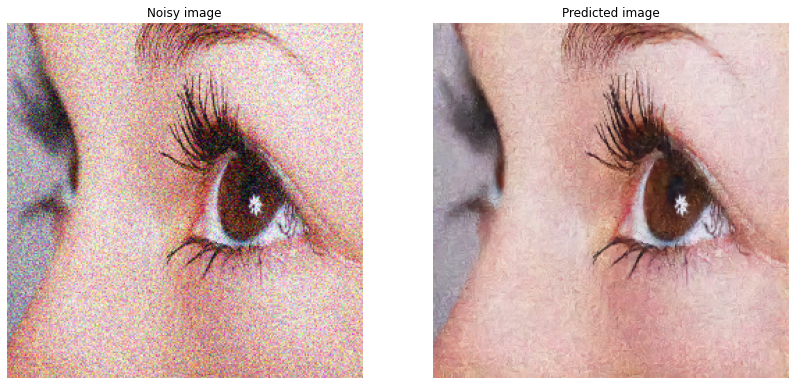

In [ ]:
# Test image prediction
banana = "NIND_banana_ISOH3.png"
kibbles = "NIND_kibbles_ISOH3.png"
library = "NIND_BruegelLibraryS1_NZ.png"
parrots = "kodim23-noise-std51.png"
eye = "eye_closeup_smaller_DIM25_noise_stddev_51.png"

img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/MWCNN/"+eye

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(img)
axarr[0].title.set_text("Noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(predicted_image)
axarr[1].title.set_text("Predicted image")
axarr[1].set_axis_off()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 26.377910119463
Predicted average gt-predicted PSNR -> 33.310521670940844


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.6000797315476446
Predicted average gt-predicted SSIM -> 0.8533562971391985


In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
print("Note: Improvements shown are over original pairs")
pt.field_names = ["Model", "PSNR", "SSIM", "PSNR Improvement", "SSIM improvement"]

pt.add_row(["Original X-y pairs (No Model)","26.3779","0.6000", "-", "-"])
pt.add_row(["REDNet (Baseline)","30.5713","0.7932", "4.1934","0.1932"])
pt.add_row(["MWCNN (using Wavelets)","32.5220","0.8397","6.1441","0.2397"])
pt.add_row(["PRIDNet (using Attention)","33.3105","0.8534","6.9326","0.2534"])

print(pt)

Note: Improvements shown are over original pairs
+-------------------------------+---------+--------+------------------+------------------+
|             Model             |   PSNR  |  SSIM  | PSNR Improvement | SSIM improvement |
+-------------------------------+---------+--------+------------------+------------------+
| Original X-y pairs (No Model) | 26.3779 | 0.6000 |        -         |        -         |
|       REDNet (Baseline)       | 30.5713 | 0.7932 |      4.1934      |      0.1932      |
|     MWCNN (using Wavelets)    | 32.5220 | 0.8397 |      6.1441      |      0.2397      |
|   PRIDNet (using Attention)   | 33.3105 | 0.8534 |      6.9326      |      0.2534      |
+-------------------------------+---------+--------+------------------+------------------+
